Todos
* Recursive Feature Elimination
    * from sklearn.feature_selection import RFE

In [ ]:
# Add table of contents

In [70]:
import pandas as pd
import numpy as np

# Tools
from collections import Counter
import pickle
# import joblib
# svc_model = joblib.load('../models/SVC_20k.pkl')

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Model Prep & Selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Feature Importance
from xgboost import plot_importance

# Visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

# Train and Test Splitting

In [2]:
# Load dataframe
df = pd.read_pickle('../data/df_clean_5k_Jan19.pkl')

# # TEMPORARY
# df = df.sample(5000)

df.head()

,case_id,is_duplicate,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,...,source,opened_year,opened_month_sin,opened_month_cos,opened_week_sin,opened_week_cos,opened_day_sin,opened_day_cos,opened_hour_sin,opened_hour_cos
772129,10390775,0,2019-01-22 14:02:41,2019-01-22 18:08:07,2019-01-22 18:08:07,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,...,Mobile/Open311,2019,0.5,0.866025,0.464723,0.885456,0.781831,0.623490,-5.000000e-01,-0.866025
790082,10347011,0,2019-01-11 20:08:06,2019-01-12 12:47:43,2019-01-12 12:47:43,Case Resolved - WASTE NOT FOUND,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Electronics,...,Mobile/Open311,2019,0.5,0.866025,0.239316,0.970942,-0.433884,-0.900969,-8.660254e-01,0.500000
788739,10349923,0,2019-01-12 20:36:00,2019-01-14 07:16:09,2019-01-14 07:16:09,Encampment Removed\nhandled,HSOC Queue,Encampments,Encampment Reports,Encampment Cleanup,...,Phone,2019,0.5,0.866025,0.239316,0.970942,-0.974928,-0.222521,-8.660254e-01,0.500000
773049,10388187,1,2019-01-22 09:08:00,2019-01-22 09:50:55,2019-01-22 09:50:55,Case is a Duplicate - This issue has already b...,Parking Enforcement Dispatch Queue,Parking Enforcement,Blocking_Driveway_Cite_Only,Blue - BMW - 7vfv578,...,Mobile/Open311,2019,0.5,0.866025,0.464723,0.885456,0.781831,0.623490,7.071068e-01,-0.707107
782771,10364426,0,2019-01-16 12:26:35,2019-01-16 15:44:07,2019-01-16 15:44:07,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,...,Mobile/Open311,2019,0.5,0.866025,0.354605,0.935016,0.974928,-0.222521,1.224647e-16,-1.000000


In [3]:
# Columns to exclude
exclude_cols = [
    'is_duplicate', # Target variable
    'case_id',
    'opened', # Needs Feature Eng
    'closed', # Needs Feature Eng
    'updated',
    'responsible_agency', # Needs NLP
    'status_notes', # Needs NLP
    'request_type', # Needs NLP
    'request_details', # Needs NLP
    'address', # Needs NLP
#     'street', # Convert to 'category' type to get dummies
    'point'
]

# # Scale data using MinMax scaler
# # No need to standardize as all features are categorical (maybe scale lat/long....)
# scaler = MinMaxScaler()

# Predictor variables
x_variables_df = df.drop(columns=exclude_cols, axis=0, inplace=False)

# Get dummies for categorical variables
X = pd.get_dummies(x_variables_df, drop_first=True)

# Target variable
y = df['is_duplicate']

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=2020, 
                                                    stratify=y,  # Stratify to keep same class ratios
                                                    shuffle=True # Shuffle data since it's ordered chronologically
                                                   )
X_train.head()

,latitude,longitude,opened_month_sin,opened_month_cos,opened_week_sin,opened_week_cos,opened_day_sin,opened_day_cos,opened_hour_sin,opened_hour_cos,...,police_district_PARK,police_district_RICHMOND,police_district_SOUTHERN,police_district_TARAVAL,police_district_TENDERLOIN,source_Mobile/Open311,source_Other Department,source_Phone,source_Twitter,source_Web
783400,37.795578,-122.423574,0.5,0.866025,0.354605,0.935016,0.974928,-0.222521,0.965926,-0.258819,...,0,0,0,0,0,1,0,0,0,0
777142,37.766731,-122.419444,0.5,0.866025,0.354605,0.935016,-0.974928,-0.222521,0.500000,-0.866025,...,0,0,0,0,0,1,0,0,0,0
801708,37.763075,-122.434191,0.5,0.866025,0.120537,0.992709,-0.974928,-0.222521,0.707107,-0.707107,...,0,0,0,0,0,0,0,0,1,0
805670,37.757858,-122.414743,0.5,0.866025,0.120537,0.992709,0.433884,-0.900969,0.707107,-0.707107,...,0,0,0,0,0,1,0,0,0,0
785763,37.783691,-122.392838,0.5,0.866025,0.354605,0.935016,0.000000,1.000000,-0.500000,-0.866025,...,0,0,1,0,0,0,0,1,0,0


In [4]:
print('df\t', df.shape)
print('X_train\t', X_train.shape)
print('X_test\t', X_test.shape)
print('y_train\t', y_train.shape)
print('y_test\t', y_test.shape)

df	 (4846, 28)
X_train	 (3876, 1052)
X_test	 (970, 1052)
y_train	 (3876,)
y_test	 (970,)


## Class Balancing

In [5]:
# Target variable
target_count = df['is_duplicate'].value_counts()

# Print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 3)*100}')

Class 0: 4467
Class 1: 379
Proportion: 11.79 : 1
Percentage of Majority Class: 92.2


In [6]:
# A ratio of .5 is saying that 50% of my data is simulated
# Trevor noted that .2 would be good but let's try different ratios
smote = SMOTE(random_state=2020)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
Counter(y_train_smote)
# pd.Series(y_train_smote).value_counts().plot.bar()

Counter({0: 3573, 1: 3573})

# Modeling

Objective: Maximize ROC AUC Score as both recall and precision are equally important and the classes are imbalanced

In [7]:
# Create list of model and performance
model_performance = []
models_optimized = []

User RandomizedSearchCV instead:
https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85


# Baseline Models

In [9]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy= 'most_frequent').fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

#Distribution of y test
print('y actual\t:', Counter(y_test))

#Distribution of y predicted
print('y predicted\t:', Counter(y_pred))

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, y_pred)))

y actual	: Counter({0: 894, 1: 76})
y predicted	: Counter({0: 970})

Confusion Matrix
[[894   0]
 [ 76   0]]


In [11]:
base_models = []

# Instantiate the models
base_models.append(('LogisticRegression', LogisticRegression(solver='liblinear')))
# base_models.append(('SVC', SVC(gamma='auto')))
base_models.append(('KNeighbors', KNeighborsClassifier()))
base_models.append(('RandomForest', RandomForestClassifier(n_estimators=10)))
base_models.append(('XGBoost', XGBClassifier()))

cv_results = []
names = []

# Cross Validate - 5 fold
for name, model in base_models:
    names.append(name)
    cv_results.append(np.round_(cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc'), 3))
#     with open(f'../models/{name}_20k.pkl', 'wb') as f: # how can I save the model for later use?ii
#         pickle.dump(model, f)

for i in range(len(names)):
    print(names[i], round(cv_results[i].mean(), 3))

LogisticRegression 0.963
KNeighbors 0.881
RandomForest 0.984
XGBoost 0.984


## Logistic Regression

In [12]:
# Grid searching key hyperparameters for logistic regression

# Instantiate model and SMOTE
lg_model = LogisticRegression()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('lgr', lg_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'lgr__solver': ['saga', 'liblinear'],
    'lgr__penalty': ['l1', 'l2'],
    'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# lg_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
lg_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = lg_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(lg_grid.best_score_)
# print(lg_grid.best_params_)

Best Score: 0.967
Params: {'smt__random_state': 2020, 'lgr__solver': 'liblinear', 'lgr__penalty': 'l2', 'lgr__C': 10}

Train 0.85	Test 0.845	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l2', 'lgr__C': 100}
Train 0.85	Test 0.845	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l1', 'lgr__C': 100}
Train 0.846	Test 0.841	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l1', 'lgr__C': 1}
Train 0.892	Test 0.886	Params: {'smt__random_state': 2020, 'lgr__solver': 'liblinear', 'lgr__penalty': 'l1', 'lgr__C': 0.1}
Train 0.5	Test 0.5	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l1', 'lgr__C': 0.001}
Train 0.82	Test 0.816	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l1', 'lgr__C': 0.1}
Train 0.936	Test 0.926	Params: {'smt__random_state': 2020, 'lgr__solver': 'liblinear', 'lgr__penalty': 'l2', 'lgr__C': 0.1}
Train 0.991	Test 0.967	Params: {'smt__random_

In [38]:
# Instantiate model with best paramaters
lg_best = LogisticRegression(C=10, penalty='l2', solver='liblinear', random_state=2020) # Check the params

# Train with balanced classes
lg_best.fit(X_train_smote, y_train_smote)

# Get predictions
lg_best_preds = lg_best.predict(X_test)
# lg_best_y_score = lg_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test, lg_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test, lg_best_preds), 3)
precision = round(precision_score(y_test, lg_best_preds), 3)
recall    = round(recall_score(y_test, lg_best_preds), 3)
f1        = round(f1_score(y_test, lg_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, lg_best_preds)))

Accuracy  : 0.87
ROC_AUC   : 0.562
Precision : 0.188
Recall    : 0.197
F-score   : 0.192

Confusion Matrix
[[829  65]
 [ 61  15]]


>Why are my scores high in the CV but much lower after using best params?
>* The FP Rate is really high...

In [39]:
# Add model and accuracy dict to list
model_performance.append(dict([
    ('Model', 'Logistic Regression'),
    ('ROC AUC', round(roc_auc, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(fscore, 3))
     ]))

# Add model to list
models_optimized.append('Logistic Regression')

# KNN

In [40]:
# Grid searching key hyperparameters for KNN

# Instantiate model and SMOTE
knn_model = KNeighborsClassifier()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('knn', knn_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'knn__n_neighbors' : [3, 5, 7]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# knn_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
knn_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = knn_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(knn_grid.best_score_)
# print(knn_grid.best_params_)

/home/corraljrmiguel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Score: 0.889
Params: {'smt__random_state': 2020, 'knn__n_neighbors': 7}

Train 0.995	Test 0.849	Params: {'smt__random_state': 2020, 'knn__n_neighbors': 3}
Train 0.991	Test 0.873	Params: {'smt__random_state': 2020, 'knn__n_neighbors': 5}
Train 0.987	Test 0.889	Params: {'smt__random_state': 2020, 'knn__n_neighbors': 7}


In [41]:
# Instantiate model with best paramaters
knn_best = KNeighborsClassifier(n_neighbors=7)

# Train with balanced classes
knn_best.fit(X_train_smote, y_train_smote)

# Get predictions
knn_best_preds = knn_best.predict(X_test)
# knn_best_y_score = knn_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  knn_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   knn_best_preds), 3)
precision = round(precision_score(y_test, knn_best_preds), 3)
recall    = round(recall_score(y_test,    knn_best_preds), 3)
f1        = round(f1_score(y_test,        knn_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, knn_best_preds)))

Accuracy  : 0.388
ROC_AUC   : 0.559
Precision : 0.091
Recall    : 0.763
F-score   : 0.163

Confusion Matrix
[[318 576]
 [ 18  58]]


In [42]:
# Add model and accuracy dict to list
model_performance.append(dict([
    ('Model', 'KNN'),
    ('ROC AUC', round(roc_auc, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(fscore, 3))
     ]))

# Add model to list
models_optimized.append('KNN')

## Random Forest

In [43]:
# Grid searching key hyperparameters for Random Forest

# Instantiate model and SMOTE
rf_model = RandomForestClassifier()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('rfc', rf_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'rfc__n_estimators': [50, 100, 150, 200, 1000],
    'rfc__max_depth' : [2, 3, 4],
    'rfc__max_features' : [5, 10, 15],
    'rfc__criterion' : ['gini', 'entropy'],
    'rfc__random_state' :[2020]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# rf_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
rf_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = rf_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(rf_grid.best_score_)
# print(rf_grid.best_params_)

Best Score: 0.908
Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 1000, 'rfc__max_features': 10, 'rfc__max_depth': 4, 'rfc__criterion': 'gini'}

Train 0.885	Test 0.863	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 100, 'rfc__max_features': 10, 'rfc__max_depth': 4, 'rfc__criterion': 'entropy'}
Train 0.881	Test 0.866	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 200, 'rfc__max_features': 15, 'rfc__max_depth': 2, 'rfc__criterion': 'gini'}
Train 0.899	Test 0.876	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 200, 'rfc__max_features': 5, 'rfc__max_depth': 3, 'rfc__criterion': 'gini'}
Train 0.903	Test 0.888	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 1000, 'rfc__max_features': 15, 'rfc__max_depth': 2, 'rfc__criterion': 'gini'}
Train 0.897	Test 0.879	Params: {'smt__random_state': 2020, 'rfc__random_state': 

In [45]:
# Instantiate model with best paramaters
rf_best = RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=2020)

# Train with balanced classes
rf_best.fit(X_train_smote, y_train_smote)

# Get predictions
rf_best_preds = rf_best.predict(X_test)
# rf_best_y_score = rf_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  rf_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   rf_best_preds), 3)
precision = round(precision_score(y_test, rf_best_preds), 3)
recall    = round(recall_score(y_test,    rf_best_preds), 3)
f1        = round(f1_score(y_test,        rf_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, rf_best_preds)))

Accuracy  : 0.782
ROC_AUC   : 0.611
Precision : 0.157
Recall    : 0.408
F-score   : 0.227

Confusion Matrix
[[728 166]
 [ 45  31]]


In [46]:
# Add model and accuracy dict to list
model_performance.append(dict([
    ('Model', 'Random Forest'),
    ('ROC AUC', round(roc_auc, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(fscore, 3))
     ]))

# Add model to list
models_optimized.append('Random Forest')

## XGBoost

In [47]:
# Grid searching key hyperparameters for XGBoost

# Instantiate model and SMOTE
xgb_model = XGBClassifier()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('xgb', xgb_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'xgb__n_estimators': [100, 250, 500, 1000], 
    'xgb__max_depth': [3, 4, 5], 
    'xgb__learning_rate': [0.001, 0.01, 0.1]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# xgb_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
xgb_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = xgb_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(lg_grid.best_score_)
# print(lg_grid.best_params_)

Best Score: 0.982
Params: {'xgb__n_estimators': 1000, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}

Train 0.902	Test 0.896	Params: {'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}
Train 0.983	Test 0.975	Params: {'xgb__n_estimators': 1000, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}
Train 0.993	Test 0.982	Params: {'xgb__n_estimators': 1000, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}
Train 0.995	Test 0.979	Params: {'xgb__n_estimators': 500, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'smt__random_state': 2020}
Train 0.998	Test 0.981	Params: {'xgb__n_estimators': 250, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'smt__random_state': 2020}
Train 1.0	Test 0.979	Params: {'xgb__n_estimators': 1000, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'smt__random_state': 2020}
Train 0.995	Test 0.981	Params: {'xgb__n_estimators': 250, 'xgb__max

In [48]:
# Instantiate model with best paramaters
xgb_best = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01)

# Train with balanced classes
xgb_best.fit(X_train_smote, y_train_smote)

# Get predictions
xgb_best_preds = xgb_best.predict(X_test)
# xgb_best_y_score = xgb_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  rf_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   rf_best_preds), 3)
precision = round(precision_score(y_test, rf_best_preds), 3)
recall    = round(recall_score(y_test,    rf_best_preds), 3)
f1        = round(f1_score(y_test,        rf_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, xgb_best_preds)))

Accuracy  : 0.782
ROC_AUC   : 0.611
Precision : 0.157
Recall    : 0.408
F-score   : 0.227

Confusion Matrix
[[880  14]
 [ 66  10]]


In [49]:
# Add model and accuracy dict to list
model_performance.append(dict([
    ('Model', 'XGBoost'),
    ('ROC AUC', round(roc_auc, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(fscore, 3))
     ]))

# Add model to list
models_optimized.append('XGBoost')

# Feature Selection

Text(0.5, 1.0, 'Feature Importance')

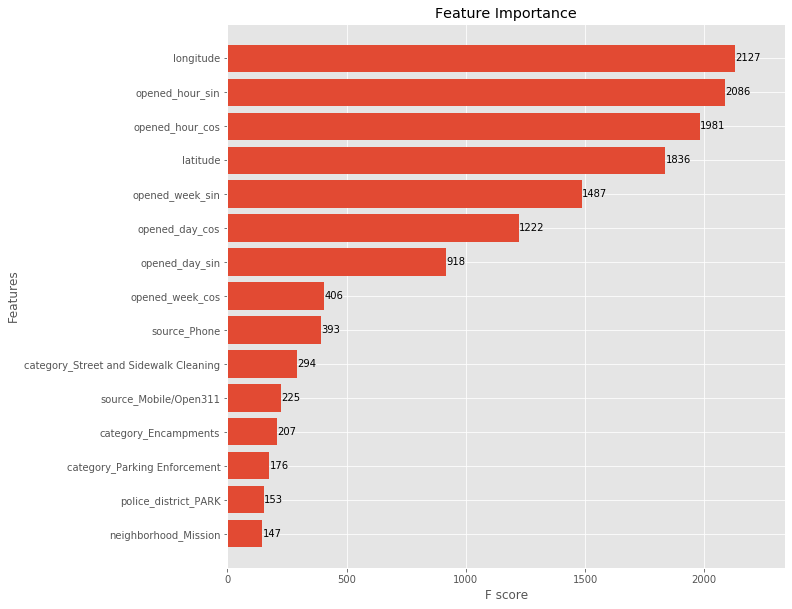

In [80]:
# Feature Importance – XGBoost
fig, ax = plt.subplots(figsize=(10,10))
xgb_best.get_booster().feature_names = list(X_test.columns)
plot_importance(xgb_best.get_booster(), max_num_features=15, height=0.8, ax=ax)
plt.title('Feature Importance')

# plt.savefig('feature_importance.png', bbox_inches='tight');

# Model Comparison

In [68]:
def plot_roc_curves(classifiers, X_train, y_train, X_test, y_test, sampler = None):
    """
        Function for plotting roc curves of classifiers for comparison
        
        :param classifiers: dictionary of classifiers
        :param sampler: sampling method to use e.g. SMOTE
        
        :returns fpr: an array of false positive rate values from roc_curve
        :returns tpr: an array of true positive rate values from roc_curve
        :returns thresholds: an array of threshold values from roc_curve
        :returns roc_auc: roc_auc scores for each classifier in classifiers
        
        https://github.com/kevinchiv/Predicting-Kickstarter-Success/blob/master/02%20-%20Classification%20Modeling.ipynb
    """

    fpr, tpr, thresholds = {}, {}, {}
    roc_auc = {}


    for classifier_name, classifier in classifiers.items():

        #set n_jobs = -1 for faster performance
        classifier = classifier.set_params(n_jobs = -1)

#         if sampler:
#             sampler.set_params(random_state = 42, n_jobs = -1)

        steps = [('sampling', sampler),
                 (classifier_name, classifier)]

        model = Pipeline(steps)

        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:,1]

        fpr[classifier_name], tpr[classifier_name], thresholds[classifier_name] = roc_curve(y_test, y_proba)

        roc_auc[classifier_name] = round(auc(fpr[classifier_name], tpr[classifier_name]), 3)

        print(classifier_name + ' roc_auc score: ' + str(roc_auc[classifier_name]))


    plt.figure(figsize=(8, 8))

    for classifier_name, classifier in classifiers.items():
        sns.lineplot(fpr[classifier_name], tpr[classifier_name], err_style = None);

    midline_points = np.arange(0, 1.05, 0.05) 

    plt.plot(midline_points, midline_points, linestyle ='--', color = 'black');
    plt.title("ROC Curves for Different Classification Models", y =1.05, fontsize = 16);
    plt.xlabel('FPR', fontsize = 12, x = 1.05);
    plt.ylabel('TPR', fontsize = 12, rotation =0, y = 1.05);
    plt.legend(list(zip(classifiers.keys(), roc_auc.values())));

    return fpr, tpr, thresholds, roc_auc

KNN roc_auc score: 0.604
LGR roc_auc score: 0.626


/home/corraljrmiguel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


RFC roc_auc score: 0.702
XGB roc_auc score: 0.712
Ensemble roc_auc score: 0.681


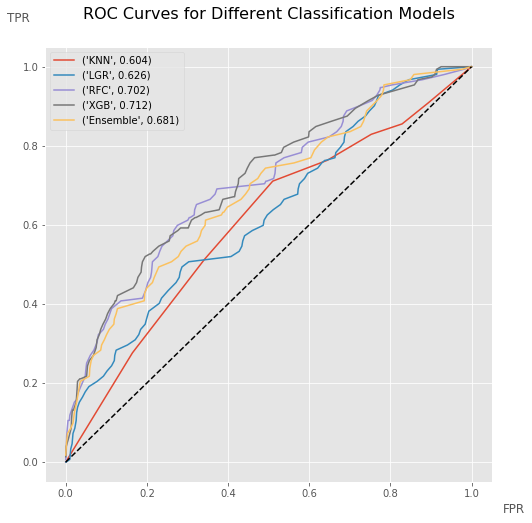

In [72]:
classifiers = {'KNN': knn_best, 
               'LGR': lg_best, 
               'RFC': rf_best, 
               'XGB': xgb_best,
               'Ensemble': VotingClassifier(estimators=[('lr', lg_best), ('rf', rf_best), ('xgb', xgb_best)],
                                            voting='soft', weights=[1, 1, 1])
              }

fpr, tpr, thresholds, roc_auc = plot_roc_curves(classifiers, X_train_smote, y_train_smote, X_test, y_test)

## Confusion Matrix for Test Dataset

In [ ]:
# # Print confusion matrix for XGBoost
# xgb_confusion = confusion_matrix(y_test, test_pred_smote)

# plt.figure(dpi=125)
# sns.heatmap(xgb_confusion, annot=True, fmt='g', square=True, cbar=False,
#             xticklabels=['no duplicate', 'is duplicate'],
#             yticklabels=['no duplicate', 'is duplicate'])

# plt.title('Confusion Matrix - Test Dataset\nXGBoost', pad=20)
# plt.xlabel('Predicted\n', labelpad=20)
# plt.ylabel('Actual\n', labelpad=20);